# Compute dislocation disregistry vectors for calculation_dislocation_monopoles

This Notebook is designed for reading finished calculation_dislocation_monopoles records and generating disregistry profiles

#### Library imports

In [1]:
# Standard Python libraries
from __future__ import print_function
import glob
import os
from collections import OrderedDict
from copy import deepcopy

from IPython.core.display import display, HTML

# pandas.pydata.org
import pandas as pd

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/DataModelDict
from DataModelDict import DataModelDict as DM

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

#### Plotting library imports

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font',family='Times New Roman')
mpl.rc('lines',linewidth=3)

## 1. Read Calculation Data

This section reads in raw data from a database. 

## 1. Raw Data

This section reads in or generates the raw_data associated with the calculation. 

### 1.1 Initialize database

- __dbasename__ is used here to predefine different dbase settings
- __dbase__ is the iprPy.Database object to use for accessing a database

In [3]:
dbasename = 'test'

# 'local' is a local directory
if   dbasename == 'local':
    dbase = iprPy.Database('local',   host='C:\Users\lmh1\Documents\calculations\ipr\library')

# 'test' is a local directory for testing 
elif   dbasename == 'test':
    dbase = iprPy.Database('local',   host='C:\Users\lmh1\Documents\calculations\ipr\library_test')
    
# 'curator' is a local MDCS curator
elif dbasename == 'curator':
    dbase = iprPy.Database('curator', host='http://127.0.0.1:8000/', 
                                      user='admin', 
                                      pswd='admin')

# 'iprhub' is the remote MDCS curator at iprhub
elif dbasename == 'iprhub':
    dbase = iprPy.Database('curator', host='https://iprhub.nist.gov/', 
                                      user='lmh1',
                                      pswd='C:/users/lmh1/documents/iprhub/iprhub_password.txt',
                                      cert='C:/users/lmh1/documents/iprhub/iprhub-ca.pem')
else:
    raise ValueError('unknown dbasename ' + dbasename)

### 1.2 Access records

In [4]:
proto_df = dbase.get_records_df(style='crystal_prototype')
print(str(len(proto_df)) + ' prototype records loaded')

19 prototype records loaded


In [5]:
pot_df = dbase.get_records_df(style='potential_LAMMPS')
print(str(len(pot_df)) + ' potential records loaded')

149 potential records loaded


In [6]:
raw_df = dbase.get_records_df(style='calculation_dislocation_monopole')
print(str(len(raw_df)) + ' calculation records loaded')

10 calculation records loaded


### 1.3 Check errors

In [7]:
if 'error' in raw_df:
    for error in np.unique(raw_df[pd.notnull(raw_df.error)].error):
        print(error)
        print()

Traceback (most recent call last):
  File "calc_dislocation_monopole.py", line 478, in <module>
    main(*sys.argv[1:])
  File "calc_dislocation_monopole.py", line 60, in main
    bwidth = input_dict['boundarywidth'])
  File "calc_dislocation_monopole.py", line 184, in dislocationmonopole
    system_disl = am.load('atom_dump', relaxed['dumpfile'])[0]
  File "c:\users\lmh1\documents\python-packages\atomman\atomman\core\load.py", line 24, in load
    system = am.lammps.atom_dump.load(input, prop_info)
  File "c:\users\lmh1\documents\python-packages\atomman\atomman\lammps\atom_dump.py", line 205, in load
    raise ValueError('Failed to properly load dump file '+str(data)[:50])
ValueError: Failed to properly load dump file 20000.dump




## 2. Process Data

This section processes and refines the data.

### 2.1 Identify composition

We need to identify the composition of each calculation so that we can collect duplicates and filter out artificial compounds.

- __counts__ is a dictionary counting the number of times each atype appears in a crystal prototype's unit cell (i.e. the number of symmetry equivalent sites)

In [8]:
counts = {}
for i, prototype in proto_df.iterrows():
    model = DM(dbase.get_record(name=prototype.id, style='crystal_prototype').content)
    counts[prototype.id] = np.unique(model.finds('component'), return_counts=True)[1]

- __comp_refine()__ takes a list of symbols and count of how many times each symbol appears in a structure and generates a composition string.__comp_refine__ takes a list of symbols and count of how many times each symbol appears in a structure and generates a composition string.

In [9]:
def comp_refine(symbols, counts):
    """Takes a list of symbols and count of how many times each symbol appears and generates a composition string."""
    primes = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47]
    
    sym_dict = {}
    for i in xrange(len(symbols)):
        sym_dict[symbols[i]] = counts[i]
    
    for prime in primes:
        if max(sym_dict.values()) < prime:
            break
        
        while True:
            breaktime = False
            for value in sym_dict.values():
                if value % prime != 0:
                    breaktime = True
                    break
            if breaktime:
                break
            for key in sym_dict:
                sym_dict[key] /= prime
    
    composition=''
    for key in sorted(sym_dict):
        if sym_dict[key] > 0:
            composition += key
            if sym_dict[key] != 1:
                composition += str(sym_dict[key])
            
    return composition       

In [10]:
compositions = []
for i, calc in raw_df.iterrows():
    compositions.append(comp_refine(calc.symbols, counts[calc.family]))
raw_df = raw_df.assign(composition=compositions)

### 2.2 Identify current ipr potentials 

In [11]:
# Extract versionstyle and versionnumber from potential implementation ids
versionstyle = []
versionnumber = []
for name in pot_df['id'].values:
    version = name.split('--')[-1]
    try:
        versionnumber.append(int(version[-1]))
    except:
        versionnumber.append(np.nan)
        versionstyle.append(version)
    else:
        versionstyle.append(version[:-1])

pot_df['versionstyle'] = versionstyle
pot_df['versionnumber'] = versionnumber

# Loop through unique potential id's
includeid = []
for pot_id in np.unique(pot_df.pot_id.values):
    check_df = pot_df[pot_df.pot_id == pot_id]
    check_df = check_df[check_df.versionstyle == 'ipr']
    check_df = check_df[check_df.versionnumber == check_df.versionnumber.max()]
    if len(check_df) == 1:
        includeid.append(check_df['id'].values[0])
    elif len(check_df) > 1:
        raise ValueError('Bad currentIPR check for '+pot_id)

# Identify current IPR potentials
raw_df['currentIPR'] = raw_df.potential_LAMMPS_id.isin(includeid)

### 2.4 Remove unwanted calculations

Here is where we filter out unwanted entries (i.e. rows).

- __df__ is the dataframe during/after processing and refining

In [12]:
raw_df.keys()

Index([u'C', u'K_tensor', u'LAMMPS_version', u'annealtemperature', u'calc_key',
       u'calc_script', u'dislocation_id', u'dislocation_key',
       u'energytolerance', u'error', u'family', u'forcetolerance',
       u'iprPy_version', u'load_file', u'load_options', u'load_style',
       u'maxatommotion', u'maxevaluations', u'maxiterations',
       u'potential_LAMMPS_id', u'potential_LAMMPS_key', u'potential_id',
       u'potential_key', u'preln', u'sizemults', u'status', u'symbols',
       u'composition', u'currentIPR'],
      dtype='object')

In [13]:
df = deepcopy(raw_df)

# Ignore unfinished or error calculations
df = df[df.status == 'finished']

# Ignore any implementations that are not current IPR implementations
df = df[df.currentIPR == True]

# Ignore false compounds (where # of unique symbols != # of symbols)
df = df[df.symbols.apply(lambda x: len(np.unique(x))) == df.symbols.apply(lambda x: len(x))] 

# Ignore duplicate compounds
ignore = set()
for i in xrange(len(df)):
    trunc = df.iloc[i+1:]
    matches = trunc.calc_key[  (trunc.potential_id == df.iloc[i].potential_id) 
                             & (trunc.family == df.iloc[i].family) 
                             & (trunc.composition == df.iloc[i].composition)
                             & (trunc.dislocation_id == df.iloc[i].dislocation_id)
                            ].tolist()
    ignore = ignore.union(matches)
df = df[~df.calc_key.isin(ignore)]

df.reset_index(drop=True, inplace=True)
print(str(len(df)) + ' records after filtering')

7 records after filtering


In [14]:
df

,C,K_tensor,LAMMPS_version,annealtemperature,calc_key,calc_script,dislocation_id,dislocation_key,energytolerance,error,...,potential_LAMMPS_id,potential_LAMMPS_key,potential_id,potential_key,preln,sizemults,status,symbols,composition,currentIPR
0,[[ 25.01604698 24.63956983 24.63956983 0. ...,"[[2.19088876966, 0.0366922556283, 0.0], [0.036...",27 Aug 2016-ICMS,50.0,13cc96e0-20dd-48d5-982c-8f1a1314e19e,calc_dislocation_monopole,A2--W--bcc--110-edge,9ef42bdc-ffdf-4f5e-b560-0852921c6f19,0.0,NaN,...,2015--Wilson-S-R--Na--LAMMPS--ipr1,f055d705-2973-499b-a1b8-9060226f99a8,2015--Wilson-S-R--Na,5f0a7080-5a72-49a2-885e-8083f47a144b,0.756618,"[[-40, 40], [-28, 28], [0, 2]]",finished,[Na],Na,True
1,[[ 1.50620904 0.94127279 0.94127279 0. ...,"[[0.768301734775, -0.0542457582668, 0.0], [-0....",27 Aug 2016-ICMS,0.0,4a47f125-6f43-4af3-a484-a3c762ba1193,calc_dislocation_monopole,A1--Cu--fcc--110-screw,fbb42787-440e-46cb-bce3-584857257907,0.0,NaN,...,2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1,702b81e2-b380-4659-ada4-368a6d0170d7,2009--Purja-Pun-G-P--Ni-Al,d71da5f1-db8a-46ad-a78d-c026768200af,0.233592,"[[-28, 28], [-40, 40], [0, 2]]",finished,[Ni],Ni,True
2,[[ 0.71017966 0.38408271 0.38408271 0. ...,"[[0.275151035241, -0.00305980288187, 0.0], [-0...",27 Aug 2016-ICMS,0.0,726bd0c7-a726-413e-a575-e98fdc8ba263,calc_dislocation_monopole,A1--Cu--fcc--110-screw,fbb42787-440e-46cb-bce3-584857257907,0.0,NaN,...,2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1,702b81e2-b380-4659-ada4-368a6d0170d7,2009--Purja-Pun-G-P--Ni-Al,d71da5f1-db8a-46ad-a78d-c026768200af,0.117032,"[[-28, 28], [-40, 40], [0, 2]]",finished,[Al],Al,True
3,[[ 25.01604698 24.63956983 24.63956983 0. ...,"[[1.54141120732, 0.0, -0.291517242376], [0.0, ...",27 Aug 2016-ICMS,50.0,8dfed487-57a0-42a2-90a4-70d5d19d768d,calc_dislocation_monopole,A2--W--bcc--112-edge,92aef361-9849-47be-9d61-e331921f1319,0.0,NaN,...,2015--Wilson-S-R--Na--LAMMPS--ipr1,f055d705-2973-499b-a1b8-9060226f99a8,2015--Wilson-S-R--Na,5f0a7080-5a72-49a2-885e-8083f47a144b,0.532323,"[[-40, 40], [-49, 49], [0, 2]]",finished,[Na],Na,True
4,[[ 25.01604698 24.63956983 24.63956983 0. ...,"[[1.58895208281, 0.0, 0.0], [0.0, 1.5889520828...",27 Aug 2016-ICMS,50.0,a9423510-b5fd-4b38-9e7d-fbcea29d2714,calc_dislocation_monopole,A2--W--bcc--111-screw,17d4954d-4832-4997-9a39-fa084c64c105,0.0,NaN,...,2015--Wilson-S-R--Na--LAMMPS--ipr1,f055d705-2973-499b-a1b8-9060226f99a8,2015--Wilson-S-R--Na,5f0a7080-5a72-49a2-885e-8083f47a144b,0.158229,"[[-28, 28], [-49, 49], [0, 2]]",finished,[Na],Na,True
5,[[ 0.71017966 0.38408271 0.38408271 0. ...,"[[0.275057707183, 0.0, 0.0], [0.0, 0.277038442...",27 Aug 2016-ICMS,0.0,c647ab62-f92c-4be1-9123-1a6b7a90a7e5,calc_dislocation_monopole,A1--Cu--fcc--111-edge,d59f2382-17e5-4fbd-b398-407c75e6009a,0.0,NaN,...,2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1,702b81e2-b380-4659-ada4-368a6d0170d7,2009--Purja-Pun-G-P--Ni-Al,d71da5f1-db8a-46ad-a78d-c026768200af,0.179512,"[[-49, 49], [-40, 40], [0, 2]]",finished,[Al],Al,True
6,[[ 1.50620904 0.94127279 0.94127279 0. ...,"[[0.759621803049, 0.0, 0.0], [0.0, 0.780164175...",27 Aug 2016-ICMS,0.0,c7d7b508-af76-4357-8935-8311c154accc,calc_dislocation_monopole,A1--Cu--fcc--111-edge,d59f2382-17e5-4fbd-b398-407c75e6009a,0.0,NaN,...,2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1,702b81e2-b380-4659-ada4-368a6d0170d7,2009--Purja-Pun-G-P--Ni-Al,d71da5f1-db8a-46ad-a78d-c026768200af,0.374492,"[[-49, 49], [-40, 40], [0, 2]]",finished,[Ni],Ni,True


## 3. Fetch calculations to analyse

This section selects which calculations to analyse

In [15]:
Aledge_df = df[(df.composition=='Al') & (df.dislocation_id =='A1--Cu--fcc--111-edge')]
if not os.path.isdir('Al_edge'):
    os.mkdir('Al_edge')
for calc_key in Aledge_df.calc_key.values:
    tar = dbase.get_tar(name=calc_key)
    tar.extractall('Al_edge')     

In [16]:
Alscrew_df = df[(df.composition=='Al') & (df.dislocation_id =='A1--Cu--fcc--110-screw')]
if not os.path.isdir('Al_screw'):
    os.mkdir('Al_screw')
for calc_key in Alscrew_df.calc_key.values:
    tar = dbase.get_tar(name=calc_key)
    tar.extractall('Al_screw')     

## 4. Calculate disregistry

In [18]:
root_dir = 'Al_edge'
x_values = OrderedDict()
disregistry_values = OrderedDict()
for calc_dir in glob.iglob(os.path.join(root_dir, '*')):
    calc_key = os.path.basename(calc_dir)
    print(calc_key)
    
    # Load dump systems
    basesystem = am.load('atom_dump', os.path.join(calc_dir, 'base.dump'))[0]
    dislsystem = am.load('atom_dump', os.path.join(calc_dir, 'disl.dump'))[0]
    
    # Compute disregistry
    x, disregistry = am.defect.disregistry(basesystem, dislsystem)
    x_values[calc_key] = x
    disregistry_values[calc_key] = disregistry

c647ab62-f92c-4be1-9123-1a6b7a90a7e5


## plot

c647ab62-f92c-4be1-9123-1a6b7a90a7e5


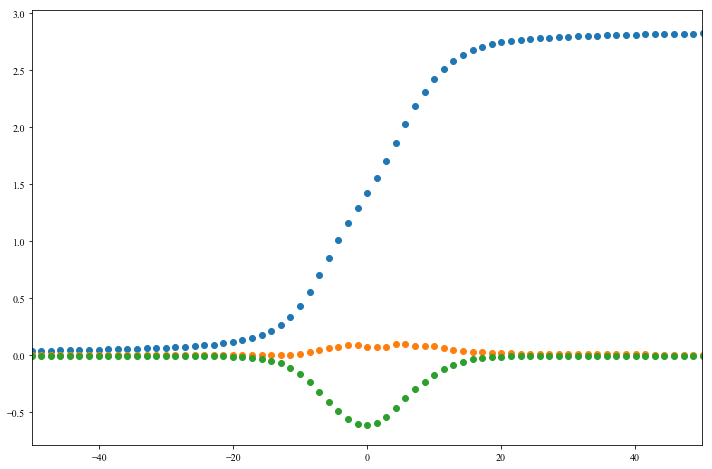

In [19]:
for calc_key in x_values:
    print(calc_key)
    fig = plt.figure(figsize=(12,8))
    plt.plot(-x_values[calc_key], disregistry_values[calc_key], 'o')
    plt.xlim(-50, 50)
    plt.show()